In [128]:
import os
import re
import sys
import numpy as np
import nibabel as nib
import ndmg.utils as mgu
from argparse import ArgumentParser
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from nilearn.plotting.edge_detect import _edge_map as edge_map
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
import pandas as pd
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import math
from ndmg import timeseries as ndt
import csv
from ndmg import register as ndr
import networkx as nx


def glm_fit(Y, X):
    """
    model Y = XB + E with Y as the voxelwise intensities and X the design matrix

    Parameters
    ----------
        Y:
            - the voxelwise intensities as a [t, v] matrix.
        X:
            - the design matrix of regressors as a [t, r] matrix.
    Returns
    -------
        E:
            - the residuals not explained by the design matrix.
    """
    # B = (X'X)^(-1)X'Y
    B = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)  # the coefs for each regressor
    E = Y - X.dot(B)  # E = Y - XB
    return E # return residuals not explained by our confound regressors

def nuis_correct(brain_file, reg_file, out_file, scrub=5):
    """
    A function for applying nuisance correction to the outputs of
    fmriprep.
    
    Parameters
    ----------
        - brain_file: string
            - the path to the preprocessed fmriprep brain.
        - reg_file: string
            - the path to a tsv of confounds from fmriprep.
        - out_file: string
            - the path for the resulting nuisance corrected brain.
    Returns
    -------
        - out_file: string
            - the path for the resulting nuisance corrected brain.
    """
    # load inputs
    brain_im = nib.load(brain_file)
    # generate numpy array from 1:n rows of the confound file
    # load the brain data
    brain_dat = brain_im.get_data()[:,:,:,scrub:]
    reg = np.genfromtxt(reg_file, delimiter='\t')[1:,:]
    # get the regressor names
    with open(reg_file) as rf:
        reg_names = csv.reader(rf, delimiter='\t')
        names = reg_names.next()
    reg = reg[scrub:,:]
    # regressors of interest are 6 motion params, acompcor, fd
    reg_of_interest = ['a_comp_cor', 'rot_', 'trans_', 'framewise_displacement']
    reg_to_use = np.array([any(x in name for x in reg_of_interest) for name in names])
    X = reg[:, reg_to_use]  # the design matrix
    X = np.column_stack((X, np.ones(X.shape[0])))  # remove mean signal per voxel
    X = np.column_stack((X, np.array(range(0, X.shape[0]))))  # remove linear trend per voxel
    X = np.column_stack((X, np.array(range(0, X.shape[0]))**2))  # remove quadratic trend per voxel
    X[0, 0] = 0  # FD is not defined for first volume, so just start at 0
    # reformat the voxelwise timeseries to be [timesteps, voxels]
    # a superficial mask so that we don't pull voxels with zero signal
    # this would lead to non-invertibility
    basic_mask = brain_dat.sum(axis=3) > 0
    Y = brain_dat[basic_mask, :].T  # the brain with zero-weight voxels removed, as a [timesteps, voxels] array

    B = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)  # the coefs for each regressor
    Y_corrected = Y - X.dot(B)  # E = Y - XB

    # put back into the data glob
    brain_dat[basic_mask, :] = Y_corrected.T
    new_im = nib.Nifti1Image(brain_dat, header=brain_im.header, affine=brain_im.affine)
    nib.save(new_im, out_file)
    return (out_file, basic_mask)


def plot_mtx(A, title=""):
    """
    A basic function to plot an adjacency matrix.
    """
    Adf = pd.DataFrame(A).stack().rename_axis(['y', 'x']).reset_index(name="Weight")
    trace = go.Heatmap(x=Adf.x, y=Adf.y, z=Adf.Weight)
    data = [trace]
    layout=go.Layout(width=550, height=550,
                     title=title,
                     xaxis=dict(title="Node Out"),
                     yaxis=dict(title="Node In", autorange="reversed"), validate=False)
    fig = go.Figure(data=data, layout=layout, validate=False)
    iplot(fig, validate=False)
    

def opaque_colorscale(basemap, reference, vmin=None, vmax=None, alpha=1):
    """
    A function to return a colorscale, with opacities
    dependent on reference intensities.
    **Positional Arguments:**
        - basemap:
            - the colormap to use for this colorscale.
        - reference:
            - the reference matrix.
    """
    reference = reference
    if vmin is not None:
        reference[reference > vmax] = vmax
    if vmax is not None:
        reference[reference < vmin] = vmin
    cmap = basemap(reference)
    maxval = np.nanmax(reference)
    # all values beteween 0 opacity and 1
    opaque_scale = alpha*reference/float(maxval)
    # remaps intensities
    cmap[:, :, 3] = opaque_scale
    return cmap


def plot_brain(brain, minthr=2, maxthr=95, edge=False):
    brain = mgu.get_braindata(brain)
    cmap = LinearSegmentedColormap.from_list('mycmap2', ['black', 'green'])
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    fbr = plt.figure()
    if brain.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = brain.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    min_val, max_val = get_min_max(brain, minthr, maxthr)
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = fbr.add_subplot(3, 3, idx)
            ax.set_axis_bgcolor('black')
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(brain[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(brain[:, pos, :], 90)
            else:
                image = brain[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            if edge:
                image = edge_map(image).data
            ax.imshow(image, interpolation='none', cmap=cmap, alpha=1,
                      vmin=min_val, vmax=max_val)

    fbr.set_size_inches(12.5, 10.5, forward=True)
    fbr.tight_layout()
    return fbr


def plot_overlays(atlas, b0, cmaps=None, minthr=2, maxthr=95, edge=False):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})
    foverlay = plt.figure()

    atlas = mgu.get_braindata(atlas)
    b0 = mgu.get_braindata(b0)
    if atlas.shape != b0.shape:
        raise ValueError('Brains are not the same shape.')
    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list('mycmap1',
                                                  ['black', 'magenta'])
        cmap2 = LinearSegmentedColormap.from_list('mycmap2',
                                                  ['black', 'green'])
        cmaps = [cmap1, cmap2]

    if b0.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = b0.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(b0, minthr, maxthr)

    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(b0[pos, :, :], 90)
                atl = ndimage.rotate(atlas[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(b0[:, pos, :], 90)
                atl = ndimage.rotate(atlas[:, pos, :], 90)
            else:
                image = b0[:, :, pos]
                atl = atlas[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])
            if edge: 
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val

            ax.imshow(atl, interpolation='none', cmap=cmaps[0], alpha=.9)
            ax.imshow(opaque_colorscale(cmaps[1], image, alpha=.9,
                      vmin=min_val, vmax=max_val))

    foverlay.set_size_inches(12.5, 10.5, forward=True)
    foverlay.tight_layout()
    return foverlay


def get_min_max(data, minthr=2, maxthr=95):
    '''
    data: regmri data to threshold.
    '''
    min_val = np.percentile(data, minthr)
    max_val = np.percentile(data, maxthr)
    return (min_val.astype(float), max_val.astype(float))

def loadGraph(filename, modality='dwi', verb=False):
    if modality == 'dwi':
        graph = nx.read_weighted_edgelist(filename, delimiter=',')
    elif modality == 'func':
        # read first line to int list
        with open(filename, 'r') as fl:
            reader = csv.reader(fl)
            # labels
            labs = [int(x) for x in next(reader)]
        # read second line onwards to numpy array
        data = np.genfromtxt(filename, dtype=float,
            delimiter=',', skip_header=True)
        lab_map = dict(zip(range(0, len(labs)), labs))
        graph = nx.from_numpy_matrix(data)
        graph = nx.relabel_nodes(graph, lab_map)
    else:
        raise ValueError("Unsupported modality.")
    return graph 

# Nuisance Correcting fMRIprep outputs

The fMRIprep pipeline outputs only a registered brain in MNI space. Following registration, the brain still has a number of confounds, such as noise present in the white matter and motion artifacts. To correct this, we must first nuisance correct the brain. This is accomplished through the use of GLM, where we are interested in:
\begin{align*}
    \epsilon = Y - X\beta
\end{align*}
where $Y$ is our original timeseries, and $X$ is our design matrix (confounds). Then $\epsilon$ is the portion of the voxelwise timeseries not explained by the confounds in our design matrix.

In [129]:
# set file names as appropriate
fmriprepdir = '/inputs/fmriprep-out/fmriprep/sub-0025427/ses-1/func'
brain_file = '{}/sub-0025427_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(fmriprepdir)
reg_file = '{}/sub-0025427_ses-1_task-rest_desc-confounds_regressors.tsv'.format(fmriprepdir)
out_file = '{}/sub-0025427_ses-1_task-rest_desc-clean_bold.nii.gz'.format(fmriprepdir)

fmriprep_cleaned, basic_mask = nuis_correct(brain_file, reg_file, out_file)

# Registering parcellations to MNI152NLin2009cAsym

The fMRIprep pipeline uses the MNI152NLin2009cAsym parcellation, a relatively new parcellation that is not standard in FSL nor freesurfer, and does not have parcellations natively aligned in that space generally (most people still use MNI152NLin6, such as us). We must get our parcellation into MNI152NLin2009cAsym space in order to properly downsample our timeseries:

In [130]:
parcellation = '/atlases/atlases/label/desikan_space-MNI152NLin6_res-2x2x2.nii.gz'
parcellation_in_mni2009 = './desikan_in_mni2009.nii.gz'
ref = '/inputs/fmriprep-out/fmriprep/sub-0025427/ses-1/func/sub-0025427_ses-1_task-rest_desc-clean_bold.nii.gz'
ref_0 = './func_0.nii.gz'
nib.save(img=nib.Nifti1Image(dataobj=nib.load(ref).get_data()[:,:,:,0], affine=nib.load(ref).affine, header=nib.load(ref).header), filename=ref_0)
ndr().resample(parcellation, parcellation_in_mni2009, ref_0)

## Evaluating Quality

To evaluate the quality of the registration, we check the alignment of the Desikan parcellation with that of the nuisance corrected (cleaned) bold image in MNI152NLin2009cAsym space:

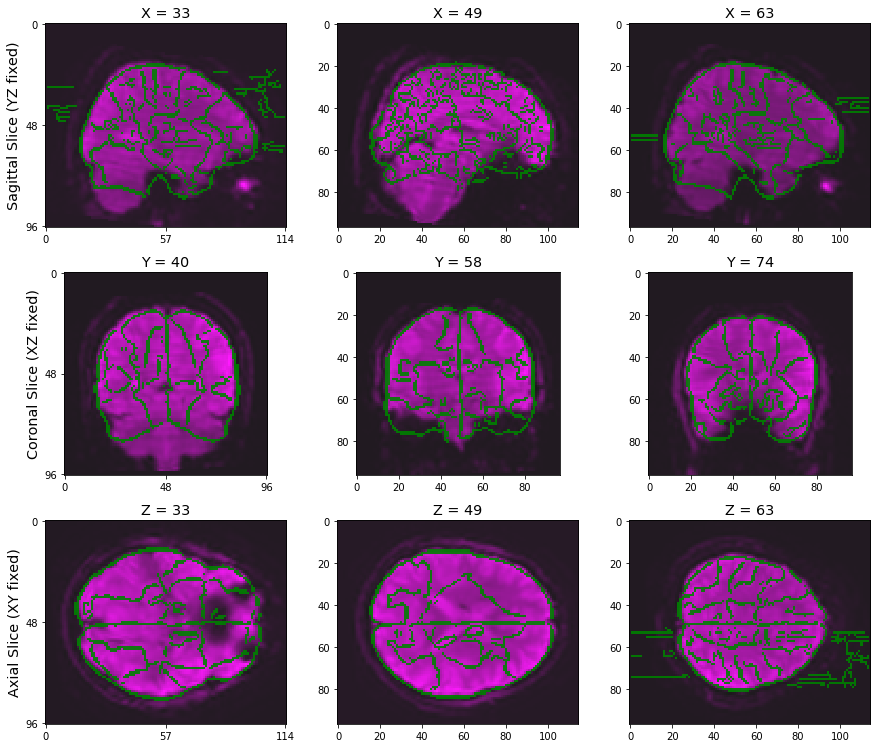

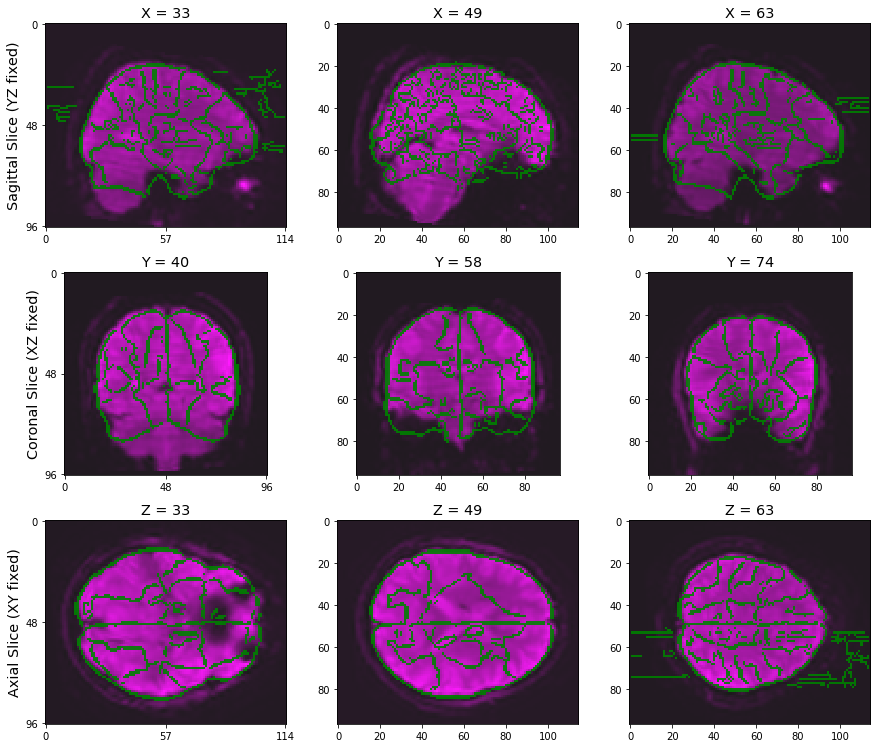

In [137]:
%matplotlib inline
plot_overlays(b0=nib.load(parcellation_in_mni2009).get_data(), atlas=nib.load(brain_file).get_data()[:,:,:,0], edge=True)

Not great, but, close enough for now.

In [132]:
ts = ndt().roi_timeseries(fmriprep_cleaned, parcellation_in_mni2009)

In [133]:
fmriprep_corr = np.abs(np.corrcoef(ts[0]))  # absolute correlation for connectivity matrix

## Load Connectomes

In [134]:
# load fmriprep, ndmg-d, ndmg-f, and native space deterministic
ndmgd_gr = nx.read_weighted_edgelist('/inputs/m3r-out/dwi/roi-connectomes/desikan_res-1x1x1/sub-0025427_ses-1_dwi_desikan_res-1x1x1_measure-spatial-ds_elist.csv', delimiter=',')
ndmgd_adj = nx.to_numpy_matrix(natd_gr, np.array(natd_gr.nodes())[np.argsort(np.array(natd_gr.nodes()).astype(int))])
ndmgf_adj = np.loadtxt('/inputs/m3rfunc-out/func/roi-connectomes/desikan_res-2x2x2/sub-0025427_ses-1_task-rest_bold_desikan_res-2x2x2_measure-correlation._adj.csv', delimiter=',')
ndmgf_adj = ndmgf_adj[1:,:]
natd_adj = np.load('./native_diff_conn.npy')

In [135]:
# move to [0, 1]

In [136]:
np.savetxt('./fmriprep.csv', fmriprep_corr, delimiter=',')
np.savetxt('./ndmgd.csv', ndmgd_adj, delimiter=',')
np.savetxt('./ndmgf.csv', ndmgf_adj, delimiter=',')
np.savetxt('./natd.csv', natd_adj, delimiter=',')